In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import colorcet as cc
import plotly.express as px

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
%matplotlib inline

config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'newplot',
    'height': 500,
    'width': 900,
    'scale': 5 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

In [2]:
df=pd.read_pickle('./dataset_/dataset_cleaned_popularity.pkl')
df.drop(columns=['index', 'level_0'], inplace=True)  # Comes from pickeling the file
df.reset_index(drop=True, inplace=True)

In [3]:
df['popularity'].describe()

count    166681.000000
mean       5511.366120
std       13236.831027
min           0.800000
25%          78.400000
50%         530.400000
75%        3995.050000
max      233766.900000
Name: popularity, dtype: float64

## Popularity Prediction
This week, we started to work on our predictive mining tasks, one of them is song popularity prediction. By the end of this project, we hope that we can see what is the typical song that is getting more popular than the others in Spotify. We got two ideas in mind, which are popularity score prediction and popularity classification (popular / not popular).

### Data Pre-processing
Before jump into the main modelling task, here we'll process all of our our possible features based on its data type:

**Numerical Features**
* popularity
* artist_followers
* danceability
* energy
* loudness
* speechiness
* acoustics
* instrumentalness
* liveness
* valence
* duration_min

**Categorical Features**
* explicit
* key
* release_day

For the first round selection, we selected the features based on our knowledge and common sense, later we'll do the feature selection based on how each of them perform in some evaluation measurement or algorithm.
#### Popularity
The original value of our popularity score is the calculation of number of days and position they stayed in the Top 200 Playlist and the score is also difference for each country.

In [4]:
df.sort_values(by='popularity', ascending=False).head(5)

,country,uri,popularity,title,artist,release_type,sub_genre,artist_followers,explicit,album,release_date,track_number,tracks_in_album,danceability,energy,key,loudness,mode,speechiness,acoustics,instrumentalness,liveness,valence,tempo,time_signature,genre,days_since_release,released_after_2017,explicit_false,explicit_true,popu_max,top10_dummy,top50_dummy,cluster,duration_min,release_year,release_month,release_day
52226,Belgium,https://open.spotify.com/track/7qiZfU4dY1lWllz...,233766.9,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),2017-03-03,4,16,0.825,0.652,1,-3.183,0,0.0802,0.581,0.0,0.0931,0.931,95.977,4,pop,1349.0,1.0,1,0,1,1.0,1.0,english speaking and nordic,3.895217,2017,3,3
52232,Costa Rica,https://open.spotify.com/track/7qiZfU4dY1lWllz...,228707.2,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),2017-03-03,4,16,0.825,0.652,1,-3.183,0,0.0802,0.581,0.0,0.0931,0.931,95.977,4,pop,1349.0,1.0,1,0,1,1.0,1.0,spanish speaking,3.895217,2017,3,3
52220,Global,https://open.spotify.com/track/7qiZfU4dY1lWllz...,221571.0,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),2017-03-03,4,16,0.825,0.652,1,-3.183,0,0.0802,0.581,0.0,0.0931,0.931,95.977,4,pop,1349.0,1.0,1,0,1,1.0,1.0,global,3.895217,2017,3,3
30287,Philippines,https://open.spotify.com/track/5uCax9HTNlzGybI...,217605.8,say you wont let go,James Arthur,album,pop,6843219.0,False,Back from the Edge,2016-10-28,2,17,0.358,0.557,10,-7.398,1,0.0590,0.695,0.0,0.0902,0.494,85.043,4,pop,1469.0,0.0,1,0,2,1.0,1.0,southern europe and portuguese heritage,3.524450,2016,10,28
52252,Singapore,https://open.spotify.com/track/7qiZfU4dY1lWllz...,217307.4,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),2017-03-03,4,16,0.825,0.652,1,-3.183,0,0.0802,0.581,0.0,0.0931,0.931,95.977,4,pop,1349.0,1.0,1,0,1,1.0,1.0,english speaking and nordic,3.895217,2017,3,3


As you can see in the table, there are multiple countries that have "Shape of You" as their top popular song, and this also means that this song is very popular compared to a song that only appears in one coutnry top playlist, right?

So, in order to get a unique song popularity score, we decided to sum up the every country's popularity score for each song, since the higher value they got, means the more popular they are.

In [5]:
df = df.groupby(['title', 'artist', 'release_type', 'sub_genre', 'artist_followers', 'explicit', 'album', 'track_number', 'tracks_in_album', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acoustics', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'genre', 'duration_min', 'release_year', 'release_month', 'release_day'])['popularity'].sum().reset_index(name='popularity')
df.sort_values(by='popularity', ascending=False).head(5)

,title,artist,release_type,sub_genre,artist_followers,explicit,album,track_number,tracks_in_album,danceability,energy,key,loudness,mode,speechiness,acoustics,instrumentalness,liveness,valence,tempo,time_signature,genre,duration_min,release_year,release_month,release_day,popularity
44367,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),4,16,0.825,0.652,1,-3.183,0,0.0802,0.581,0.000000,0.0931,0.931,95.977,4,pop,3.895217,2017,3,3,5732932.35
11089,dance monkey,Tones And I,single,australian pop,2283019.0,False,Dance Monkey,1,1,0.825,0.593,6,-6.401,0,0.0988,0.688,0.000161,0.1700,0.540,98.078,4,pop,3.495917,2019,5,10,3624590.65
38669,perfect,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),5,16,0.599,0.448,8,-6.312,1,0.0232,0.163,0.000000,0.1060,0.168,95.050,3,pop,4.390000,2017,3,3,2933691.50
4480,bad guy,Billie Eilish,album,electropop,34697267.0,False,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?",2,14,0.701,0.425,7,-10.965,1,0.3750,0.328,0.130000,0.1000,0.562,135.128,4,pop,3.234800,2019,3,29,2812179.25
44341,shallow,Lady Gaga - Bradley Cooper,album,dance pop,14439685.0,False,A Star Is Born Soundtrack,12,34,0.572,0.385,7,-6.362,1,0.0308,0.371,0.000000,0.2310,0.323,95.799,4,pop,3.595550,2018,10,5,2600171.85


As a result, we got 59,492 unique songs. Then, we tried to visualize the distribution, but it turned out that the final popularity score is too large and not easily readable. Thus, we normalized the value to a 0-100 range to make it similar with the popularity score calculated by Spotify

In [6]:
df['popularity'] = (df['popularity'] - df['popularity'].min()) / (df['popularity'].max() - df['popularity'].min()) * 100

In [7]:
df.sort_values(by='popularity', ascending=False).head(10)

,title,artist,release_type,sub_genre,artist_followers,explicit,album,track_number,tracks_in_album,danceability,energy,key,loudness,mode,speechiness,acoustics,instrumentalness,liveness,valence,tempo,time_signature,genre,duration_min,release_year,release_month,release_day,popularity
44367,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),4,16,0.825,0.652,1,-3.183,0,0.0802,0.58100,0.000000,0.0931,0.931,95.977,4,pop,3.895217,2017,3,3,100.000000
11089,dance monkey,Tones And I,single,australian pop,2283019.0,False,Dance Monkey,1,1,0.825,0.593,6,-6.401,0,0.0988,0.68800,0.000161,0.1700,0.540,98.078,4,pop,3.495917,2019,5,10,63.224021
38669,perfect,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),5,16,0.599,0.448,8,-6.312,1,0.0232,0.16300,0.000000,0.1060,0.168,95.050,3,pop,4.390000,2017,3,3,51.172610
4480,bad guy,Billie Eilish,album,electropop,34697267.0,False,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?",2,14,0.701,0.425,7,-10.965,1,0.3750,0.32800,0.130000,0.1000,0.562,135.128,4,pop,3.234800,2019,3,29,49.053062
44341,shallow,Lady Gaga - Bradley Cooper,album,dance pop,14439685.0,False,A Star Is Born Soundtrack,12,34,0.572,0.385,7,-6.362,1,0.0308,0.37100,0.000000,0.2310,0.323,95.799,4,pop,3.595550,2018,10,5,45.354999
45968,someone you loved,Lewis Capaldi,album,pop,5649718.0,False,Divinely Uninspired To A Hellish Extent,4,12,0.501,0.405,1,-5.679,1,0.0319,0.75100,0.000000,0.1050,0.446,109.891,4,pop,3.036017,2019,5,17,43.638799
44304,señorita,Shawn Mendes - Camila Cabello,album,canadian pop,29743681.0,False,Shawn Mendes (Deluxe),1,16,0.759,0.548,9,-6.049,0,0.0290,0.03920,0.000000,0.0828,0.749,116.967,4,pop,3.180000,2019,6,19,43.184823
34452,new rules,Dua Lipa,album,dance pop,20575026.0,False,Dua Lipa (Deluxe),10,17,0.762,0.700,9,-6.021,0,0.0694,0.00261,0.000016,0.1530,0.608,116.073,4,pop,3.488667,2017,6,2,42.167052
11936,despacito - remix,Luis Fonsi - Daddy Yankee - Justin Bieber,single,latin,8932627.0,False,Despacito Feat. Justin Bieber (Remix),1,1,0.694,0.815,2,-4.328,1,0.1200,0.22900,0.000000,0.0924,0.813,88.931,4,latin,3.813783,2017,4,17,41.524686
45990,something just like this,The Chainsmokers - Coldplay,album,dance pop,16931568.0,False,Memories...Do Not Open,5,12,0.617,0.635,11,-6.769,0,0.0317,0.04980,0.000014,0.1640,0.446,103.019,4,pop,4.119333,2017,4,7,41.099031


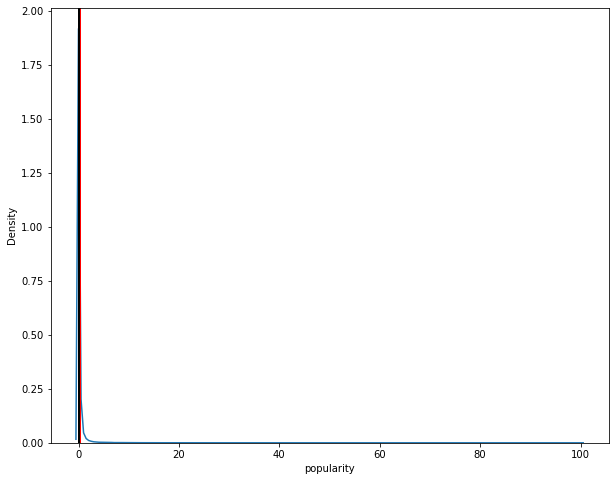

In [8]:
plt.figure(figsize=(10, 8))
sns.kdeplot(df['popularity'])

plt.axvline(df['popularity'].mean(), linewidth = 2, color = 'r')
plt.axvline(df['popularity'].median(), linewidth = 2, color = 'k')
plt.show()

In [9]:
df['popularity'].describe()

count    59492.000000
mean         0.269332
std          1.539976
min          0.000000
25%          0.001619
50%          0.010614
75%          0.081869
max        100.000000
Name: popularity, dtype: float64

The mean is way too shifted to the left, even from 59k songs, 51k songs are below average, because the dataset has a few extreme popular songs. To resolve this issue, we tried to scale the popularity using QuantileTransformer that will transform the data into a normal distribution.

In [10]:
#df.drop(df[df['popularity'] > 0.005].index, inplace = True)

### Sklearn Scaler Trial

In [11]:
X = df['popularity'].values.reshape(-1,1)
df['popularity'] = QuantileTransformer(output_distribution="normal").fit_transform(X)

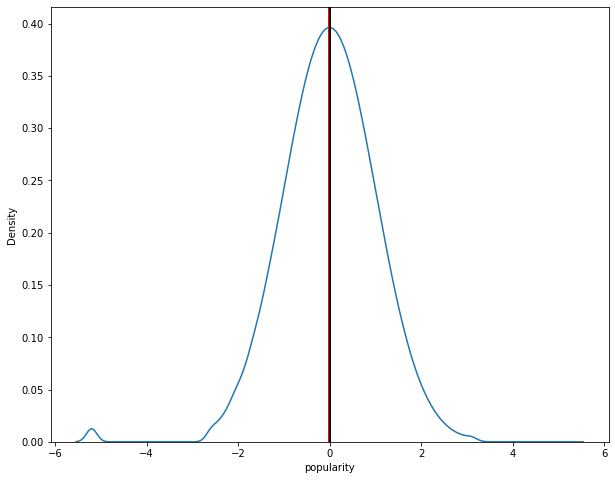

In [12]:
plt.figure(figsize=(10, 8))
sns.kdeplot(df['popularity'])

plt.axvline(df['popularity'].mean(), linewidth = 2, color = 'r')
plt.axvline(df['popularity'].median(), linewidth = 2, color = 'k')
plt.show()

In [13]:
df['popularity'].describe()

count    59492.000000
mean        -0.008236
std          1.031364
min         -5.199338
25%         -0.676854
50%         -0.000137
75%          0.674392
max          5.199338
Name: popularity, dtype: float64

In [14]:
df['popularity'] = (df['popularity'] - df['popularity'].min()) / (df['popularity'].max() - df['popularity'].min()) * 100

In [15]:
df['popularity'].describe()

count    59492.000000
mean        49.920794
std          9.918226
min          0.000000
25%         43.490958
50%         49.998679
75%         56.485367
max        100.000000
Name: popularity, dtype: float64

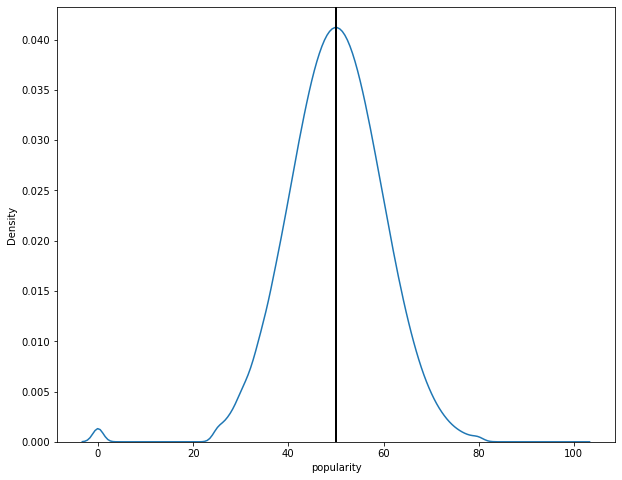

In [16]:
plt.figure(figsize=(10, 8))
sns.kdeplot(df['popularity'])

plt.axvline(df['popularity'].mean(), linewidth = 2, color = 'r')
plt.axvline(df['popularity'].median(), linewidth = 2, color = 'k')
plt.show()

In [17]:
df.sort_values(by='popularity', ascending=False).head(10)

,title,artist,release_type,sub_genre,artist_followers,explicit,album,track_number,tracks_in_album,danceability,energy,key,loudness,mode,speechiness,acoustics,instrumentalness,liveness,valence,tempo,time_signature,genre,duration_min,release_year,release_month,release_day,popularity
44367,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),4,16,0.825,0.652,1,-3.183,0,0.0802,0.58100,0.000000,0.0931,0.931,95.977,4,pop,3.895217,2017,3,3,100.000000
11089,dance monkey,Tones And I,single,australian pop,2283019.0,False,Dance Monkey,1,1,0.825,0.593,6,-6.401,0,0.0988,0.68800,0.000161,0.1700,0.540,98.078,4,pop,3.495917,2019,5,10,81.764888
38669,perfect,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),5,16,0.599,0.448,8,-6.312,1,0.0232,0.16300,0.000000,0.1060,0.168,95.050,3,pop,4.390000,2017,3,3,80.992390
4480,bad guy,Billie Eilish,album,electropop,34697267.0,False,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?",2,14,0.701,0.425,7,-10.965,1,0.3750,0.32800,0.130000,0.1000,0.562,135.128,4,pop,3.234800,2019,3,29,80.875140
44341,shallow,Lady Gaga - Bradley Cooper,album,dance pop,14439685.0,False,A Star Is Born Soundtrack,12,34,0.572,0.385,7,-6.362,1,0.0308,0.37100,0.000000,0.2310,0.323,95.799,4,pop,3.595550,2018,10,5,80.680947
45968,someone you loved,Lewis Capaldi,album,pop,5649718.0,False,Divinely Uninspired To A Hellish Extent,4,12,0.501,0.405,1,-5.679,1,0.0319,0.75100,0.000000,0.1050,0.446,109.891,4,pop,3.036017,2019,5,17,80.594911
44304,señorita,Shawn Mendes - Camila Cabello,album,canadian pop,29743681.0,False,Shawn Mendes (Deluxe),1,16,0.759,0.548,9,-6.049,0,0.0290,0.03920,0.000000,0.0828,0.749,116.967,4,pop,3.180000,2019,6,19,80.572557
34452,new rules,Dua Lipa,album,dance pop,20575026.0,False,Dua Lipa (Deluxe),10,17,0.762,0.700,9,-6.021,0,0.0694,0.00261,0.000016,0.1530,0.608,116.073,4,pop,3.488667,2017,6,2,80.523032
11936,despacito - remix,Luis Fonsi - Daddy Yankee - Justin Bieber,single,latin,8932627.0,False,Despacito Feat. Justin Bieber (Remix),1,1,0.694,0.815,2,-4.328,1,0.1200,0.22900,0.000000,0.0924,0.813,88.931,4,latin,3.813783,2017,4,17,80.492187
45990,something just like this,The Chainsmokers - Coldplay,album,dance pop,16931568.0,False,Memories...Do Not Open,5,12,0.617,0.635,11,-6.769,0,0.0317,0.04980,0.000014,0.1640,0.446,103.019,4,pop,4.119333,2017,4,7,80.471919


Once the distribution is transformed, we scale again the data into 0-100 range to make it back as the original value.
After that, we checked again which feature is needed to be pre-processed.

In [18]:
# Drop unused columns
df_selected = df.drop(["title", "artist", "sub_genre", "album", "track_number", "tracks_in_album", "time_signature", "genre"],axis=1)
y = df["popularity"]

In [19]:
df_selected.nunique(axis=0)

release_type            3
artist_followers     9134
explicit                4
danceability          990
energy               1225
key                    24
loudness            12259
mode                    4
speechiness          1512
acoustics            3551
instrumentalness     5061
liveness             1727
valence              1543
tempo               30613
duration_min        36712
release_year           79
release_month          12
release_day            31
popularity          33676
dtype: int64

From the result above, you can see that explicit and mode is supposed to have only binary value, but there is 4 unique values instead.

#### Explicit
We will change the string value of "True" and "False" into a boolean one.

In [20]:
df_selected['explicit'].unique()

array([False, True, 'True', 'False'], dtype=object)

In [21]:
df_selected.loc[df_selected.explicit == 'True', 'explicit'] = 1
df_selected.loc[df_selected.explicit == 'False', 'explicit'] = 0
df_selected.loc[df_selected.explicit == True, 'explicit'] = 1
df_selected.loc[df_selected.explicit == False, 'explicit'] = 0

In [22]:
df_selected['explicit'].unique()

array([0, 1], dtype=object)

#### Mode
We will change the string value of "0" and "1" into a numeric one.

In [23]:
df_selected['mode'].unique()

array([1, 0, '1', '0'], dtype=object)

In [24]:
df_selected.loc[df_selected['mode'] == '0', 'mode'] = 0
df_selected.loc[df_selected['mode'] == '1', 'mode'] = 1

In [25]:
df_selected['mode'].unique()

array([1, 0], dtype=object)

In [26]:
df_selected.nunique(axis=0)

release_type            3
artist_followers     9134
explicit                2
danceability          990
energy               1225
key                    24
loudness            12259
mode                    2
speechiness          1512
acoustics            3551
instrumentalness     5061
liveness             1727
valence              1543
tempo               30613
duration_min        36712
release_year           79
release_month          12
release_day            31
popularity          33676
dtype: int64

#### Key
There are duplicated keys, so we tried to convert all of them into numeric values.

In [27]:
df_selected['key'].unique()

array([1, 5, 8, 4, 11, 10, 9, 0, '1', 2, 7, 6, '9', '10', '0', 3, '5',
       '11', '4', '7', '2', '3', '6', '8'], dtype=object)

In [28]:
df_selected.loc[df_selected['key'] == '9', 'key'] = 9
df_selected.loc[df_selected['key'] == '10', 'key'] = 10
df_selected.loc[df_selected['key'] == '0', 'key'] = 0
df_selected.loc[df_selected['key'] == '5', 'key'] = 5
df_selected.loc[df_selected['key'] == '11', 'key'] = 11
df_selected.loc[df_selected['key'] == '4', 'key'] = 4
df_selected.loc[df_selected['key'] == '7', 'key'] = 7
df_selected.loc[df_selected['key'] == '2', 'key'] = 2
df_selected.loc[df_selected['key'] == '3', 'key'] = 3
df_selected.loc[df_selected['key'] == '6', 'key'] = 6
df_selected.loc[df_selected['key'] == '8', 'key'] = 8
df_selected.loc[df_selected['key'] == '1', 'key'] = 1

In [29]:
df_selected['key'].unique()

array([1, 5, 8, 4, 11, 10, 9, 0, 2, 7, 6, 3], dtype=object)

#### Release Day

In [30]:
df_selected['release_date'] = pd.to_datetime(df_selected['release_year'].astype(str) + '-' + df_selected['release_month'].astype(str) + '-' + df_selected['release_day'].astype(str), errors='ignore')
df_selected['weekday'] = df_selected['release_date'].dt.dayofweek
df_selected

,release_type,artist_followers,explicit,danceability,energy,key,loudness,mode,speechiness,acoustics,instrumentalness,liveness,valence,tempo,duration_min,release_year,release_month,release_day,popularity,release_date,weekday
0,album,306856.0,0,0.561,0.798,1,-7.064,1,0.3200,0.3070,0.000000,0.1100,0.140,140.837,3.696017,2018,2,26,51.179176,2018-02-26,0
1,album,5502398.0,1,0.725,0.543,5,-6.311,1,0.0841,0.0296,0.000000,0.1770,0.693,119.961,2.255650,2019,8,9,53.508226,2019-08-09,4
2,single,614607.0,1,0.823,0.612,1,-7.767,1,0.2480,0.1680,0.000000,0.1090,0.688,142.959,2.975550,2018,6,22,40.502140,2018-06-22,4
3,album,19841.0,1,0.655,0.498,8,-7.297,1,0.2930,0.1250,0.000014,0.1660,0.241,94.146,3.135650,2020,1,31,48.661977,2020-01-31,4
4,album,617156.0,1,0.714,0.727,4,-6.216,0,0.4160,0.2000,0.000000,0.0879,0.497,190.567,3.325150,2020,4,16,40.423226,2020-04-16,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59487,album,24755789.0,0,0.619,0.889,10,-3.108,0,0.2190,0.0483,0.000000,0.3240,0.622,77.058,4.000350,2015,4,29,50.515940,2015-04-29,2
59488,single,725478.0,0,0.540,0.535,1,-4.860,1,0.0301,0.4590,0.000000,0.1540,0.216,131.990,4.194717,2018,6,24,41.000276,2018-06-24,6
59489,album,24755789.0,0,0.583,0.885,0,-3.571,0,0.1060,0.0244,0.000000,0.3570,0.601,92.959,3.617533,2016,10,10,47.431540,2016-10-10,0
59490,album,4486644.0,0,0.832,0.896,6,-4.673,1,0.2330,0.1590,0.000048,0.2470,0.618,178.998,3.827933,2018,3,2,51.161979,2018-03-02,4


In [31]:
df_selected['weekday'].unique()

array([0, 4, 3, 2, 1, 6, 5])

In [32]:
df_selected = df_selected.drop(["release_year", "release_month", "release_day", "release_date"],axis=1)

In [33]:
df_selected.nunique(axis=0)

release_type            3
artist_followers     9134
explicit                2
danceability          990
energy               1225
key                    12
loudness            12259
mode                    2
speechiness          1512
acoustics            3551
instrumentalness     5061
liveness             1727
valence              1543
tempo               30613
duration_min        36712
popularity          33676
weekday                 7
dtype: int64

### Features Visualization
Here we wanted to recap on how all the features behave in popularity

#### Numerical data visualization

In [ ]:
plt.figure(figsize=(16, 8))
sns.pairplot(data=df,
                  x_vars=['artist_followers', 'loudness', 'danceability'],
                  y_vars=['popularity'], kind="kde")
plt.show()

In [ ]:
plt.figure(figsize=(16, 8))
sns.pairplot(data=df,
                  x_vars=['artist_followers', 'loudness', 'danceability'],
                  y_vars=['popularity'], kind="kde")
plt.show()

In [ ]:
sns.pairplot(data=df,
                  x_vars=['liveness', 'valence', 'tempo', 'duration_min'],
                  y_vars=['popularity'], kind="kde")

#### Categorical data visualization

In [35]:
df_avg_pop = df_selected.groupby('key')['popularity'].mean().reset_index(name='popularity').sort_values('popularity', ascending=False)
fig = px.bar(df_avg_pop, x='key', y='popularity',
             title='Key vs Popularity',
             height=300,
             width=600)
fig.update_layout(
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.update(layout_showlegend=False)
fig.show(config=config)

In [36]:
df_avg_pop = df_selected.groupby('mode')['popularity'].mean().reset_index(name='popularity').sort_values('popularity', ascending=False)
fig = px.bar(df_avg_pop, x='mode', y='popularity',
             title='Mode vs Popularity',
             height=300,
             width=600)
fig.update_layout(
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.update(layout_showlegend=False)
fig.show(config=config)

In [37]:
df_avg_pop = df_selected.groupby('weekday')['popularity'].mean().reset_index(name='popularity').sort_values('popularity', ascending=False)
fig = px.bar(df_avg_pop, x='weekday', y='popularity',
             title='Release day vs Popularity',
             height=300,
             width=600)
fig.update_layout(
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.update(layout_showlegend=False)
fig.show(config=config)

### Modelling

- Try specific country (Switzerland, Global)
- Including only numerical features first
- Then if it works, including the categorical features
- Try SVM Regressor, least square regression